In [22]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as io
import pandas as pd

import os
import time

In [24]:
# file_path = '../../正演数据.xlsx'  
# data = pd.read_excel(file_path, engine='openpyxl')  

# horizontal = np.array(data['水平方向'])  
# vertical = np.array(data['垂直方向'])  
# axis = np.array(data['轴向'])  
# temperature = np.array(data['温度'])  
# k = 0.7 * 1e-6

## 超参数设置

In [25]:
domain = (0, 0.25, 0, 0.25)
xmin, xmax, ymin, ymax = domain
mlp_layers = [2] + [60]*8 + [1]
mlp_layers_G = [2] + [20]*2 + [1]
n_iters = 20000
# n_iters = 200000
learning_rate = 1e-3
gamma = 0.6

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path = r'./model'
train_info_path = r'./'
if not os.path.exists(model_path):
    os.mkdir(model_path)

## 数据集生成

In [26]:
class Dataset:
    def __init__(self, domain):
        self.domain = domain
    
    def train_data(self, N=5000, verbose=None):
        # 内部点
        x_res = np.linspace(xmin, xmax, 50)
        y_res = np.linspace(ymin, ymax, 80)
        xx, yy = np.meshgrid(x_res, y_res)
        X_res = np.concatenate([xx.reshape((-1, 1)), yy.reshape((-1, 1))], axis=1)
        u_res = self.u_res_func(X_res)

        # 边界点
        observed_idx = np.concatenate([np.where(X_res[:,[0]] == xmin)[0], np.where(X_res[:,[0]] == xmax)[0], np.where(X_res[:,[1]] == ymin)[0], np.where(X_res[:,[1]] == ymax)[0]], axis=0)
        X_bcs = X_res[observed_idx]
        u_bcs = self.u_bcs_func(X_bcs)
        # T_data = temperature.reshape(-1, 1)[observed_idx]
        
        return X_res, X_bcs, u_bcs, u_res
    
    def u_bcs_func(self, X_res):
        f_bcs = (1/(2*(4*np.pi)**2)) * (np.sin(4*np.pi*X_res[:,[0]])) * (np.sin(4*np.pi*X_res[:,[1]])) 
        return f_bcs
    
    def u_res_func(self, X_res):
        f_res = (np.sin(4*np.pi*X_res[:,[0]])) * (np.sin(4*np.pi*X_res[:,[1]])) 
        return f_res
    
    def update_all_data(self):
        self.external_data()
        # self.interior_random(self.nr)
        self.func_res()
    

    def func_res(self):
        X_res = self.datad["X_res"]
        f_res = np.zeros((X_res.shape[0], 1))
        self.datad["f_res"] = f_res
    

dataset = Dataset(domain)
X_res, X_bcs, u_bcs, u_res = dataset.train_data()
dataset.update_all_data()  # 加载/更新所有数据
dataset.statistic()  # 计算数据的统计信息，用作标准化

FileNotFoundError: [Errno 2] No such file or directory: './data/温度和热源.xlsx'

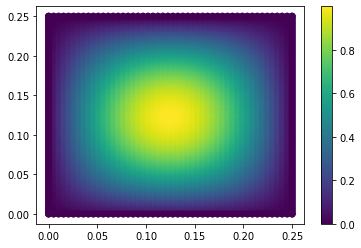

In [ ]:
X = np.concatenate([X_res,X_bcs],axis=0)
U = np.concatenate([u_res,u_bcs],axis=0)
# print()
plt.scatter(X[:,0], X[:,1],c=U)
plt.colorbar()


In [ ]:
G_D, G_M = (U.max() - U.min()), U.mean()

## PINN主干网络

In [ ]:
class MLP(nn.Module):
    def __init__(self, mlp_layers):
        super(MLP, self).__init__()
        self.model = nn.Sequential()
        for i in range(len(mlp_layers)-2):
            self.model.add_module(f'fc{i+1}', nn.Linear(mlp_layers[i], mlp_layers[i+1], bias=True))
            self.model.add_module(f'act{i+1}', nn.Tanh())
        self.model.add_module(f'fc{len(mlp_layers)-1})', nn.Linear(mlp_layers[-2], mlp_layers[-1], bias=False))
    
    def forward(self, X):
        return self.model(X)
    
    
mlp = MLP(mlp_layers)
mlp_G = MLP(mlp_layers_G)
mlp.model

Sequential(
  (fc1): Linear(in_features=2, out_features=60, bias=True)
  (act1): Tanh()
  (fc2): Linear(in_features=60, out_features=60, bias=True)
  (act2): Tanh()
  (fc3): Linear(in_features=60, out_features=60, bias=True)
  (act3): Tanh()
  (fc4): Linear(in_features=60, out_features=60, bias=True)
  (act4): Tanh()
  (fc5): Linear(in_features=60, out_features=60, bias=True)
  (act5): Tanh()
  (fc6): Linear(in_features=60, out_features=60, bias=True)
  (act6): Tanh()
  (fc7): Linear(in_features=60, out_features=60, bias=True)
  (act7): Tanh()
  (fc8): Linear(in_features=60, out_features=60, bias=True)
  (act8): Tanh()
  (fc9)): Linear(in_features=60, out_features=1, bias=False)
)

## PINN模型

In [ ]:
def grad(outputs, inputs):
    return torch.autograd.grad(outputs, inputs,
                               grad_outputs=torch.ones_like(outputs),
                               create_graph=True)

In [ ]:
class PINN(nn.Module):
    def __init__(self, backbone, nn_G, datad, mu=None, sigma=None):
        super(PINN, self).__init__()
        self.backbone = backbone
        self.nn_G = nn_G
        self.mean, self.std, self.var = datad["mean"], datad["std"], datad["var"]

        
        if mu is not None and sigma is not None:
            self.is_inputs_normalization = True
            self.mu = mu
            self.sigma = sigma
            print(f'forward with normalization, mu={self.mu.tolist()}, sigma={self.sigma.tolist()}')
        else:
            self.is_inputs_normalization = False
    
    # def forward(self, X_res, X_bcs, u_bcs_data):
    #     u_res_pred = self.net_f(X_res)
    #     u_bcs_pred = self.net_u(X_bcs)

    #     loss_res = torch.mean((u_res_pred) ** 2)
    #     loss_data = torch.mean((u_bcs_pred - u_bcs_data) ** 2)
    #     return loss_res, loss_data
    
    def forward(self,datad):
        X_res, f_res, X_obs, T_obs = datad["X_res"], datad["f_res"], datad["X_obs"], datad["T_obs"]
        f_res_pred = self.net_f(X_res)
        T_obs_pred = self.net_u(X_obs)

        # 计算point-wise loss
        loss_res_pw = (f_res_pred - f_res) ** 2
        loss_obs_pw = (T_obs_pred - T_obs) ** 2
        return loss_res_pw, loss_obs_pw

    def net_G_output_transform(self, param):
        """对net_param输出做变换，若无需变换则直接return param"""
        return param * G_D / 2 + G_M

    def net_u(self, X):
        if self.is_inputs_normalization == True:
            X = (X - self.mu) / self.sigma
        return self.backbone(X)
    
    def net_G(self, X):
        if self.is_inputs_normalization == True:
            X = (X - self.mu) / self.sigma
        return self.net_G_output_transform(self.nn_G(X))
    
    def net_f(self, X):
        X.requires_grad_(True)
        u_pred = self.net_u(X)
        
        # 求实部u的梯度
        grad_u = grad(u_pred, X)[0]
        u_x = grad_u[:, [0]]
        u_y = grad_u[:, [1]]
        
        u_xx = grad(u_x, X)[0][:, [0]]
        u_yy = grad(u_y, X)[0][:, [1]]
        
        G = self.net_G(X)
        
        f_res_pred = u_xx + u_yy + G
        
        return f_res_pred
    

pinn = PINN(mlp, mlp_G,dataset.datad)

## Adam训练

In [ ]:
# 训练
dataset = Dataset(domain)
X_res, X_bcs, u_bcs, u_res = dataset.train_data()
X_res = torch.from_numpy(X_res).float().to(device)
X_bcs = torch.from_numpy(X_bcs).float().to(device)
u_bcs = torch.from_numpy(u_bcs).float().to(device)
u_res = torch.from_numpy(u_res).float().to(device)

dataset.update_all_data()  # 加载/更新所有数据
dataset.statistic()  # 计算数据的统计信息，用作标准化

mu = X_res.mean(dim=0)
sigma = X_res.std(dim=0)  # 求样本标准差

backbone = MLP(mlp_layers)
nn_G = MLP(mlp_layers_G)
pinn = PINN(backbone, nn_G, dataset.datad, mu, sigma)
pinn = pinn.to(device)

optimizer_adam = optim.Adam(pinn.backbone.parameters(), lr=learning_rate)
optimizer_adam_param = optim.Adam(pinn.nn_G.parameters(), lr=learning_rate)
# optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001, 
# threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False
lr_sche = ReduceLROnPlateau(optimizer_adam, mode='min', factor=gamma, verbose=True)
lr_sche_param = ReduceLROnPlateau(optimizer_adam_param, mode='min', factor=gamma, verbose=True)

logger = {
    "loss": [],
    "loss_res": [],
    "loss_data": [],
    "iter": [],
    "mu": mu,
    "sigma": sigma
}
with open(train_info_path + 'train_info.txt', 'w') as f:
    f.write('Training by Adam:\n')
start_time = time.time()

for it in range(n_iters):
    pinn.zero_grad()
    # loss_res, loss_data = pinn(X_res, X_bcs, u_bcs)
    loss_res_pw, loss_obs_pw = pinn(dataset.datad)
    # loss = 10*loss_res + 1000*loss_data
    loss = loss_res_pw + loss_obs_pw
    loss.backward()
    optimizer_adam.step()
    optimizer_adam_param.step()
    
    # 保存训练信息 -------
    logger["loss"].append(loss.item())
    logger["loss_res"].append(loss_res_pw.item())
    logger["loss_data"].append(loss_obs_pw.item())
    logger["iter"].append(it + 1)
    
    if (it + 1) % 100 == 0:  # 打印训练信息 -------
        info = f'Iter # {it+1:4d}/{n_iters}\ttime:{time.time()-start_time:.1f}\t' + f'loss:{loss.item():.2e}, loss_r:{loss_res_pw.item():.2e}, loss_d:{loss_obs_pw.item():.2e}'
        with open(train_info_path + 'train_info.txt', 'a') as f:
            f.write(info + '\n')
        print(info)
        
    if (it + 1) % 100 == 0:  # 学习率衰减 -------
        lr_sche.step(loss)
        lr_sche_param.step(loss)

forward with normalization, mu=[0.125, 0.125], sigma=[0.07363609224557877, 0.0730857402086258]


Iter #  100/20000	time:16.9	loss:5.41e-03, loss_r:4.36e-04, loss_d:1.04e-06
Iter #  200/20000	time:29.9	loss:2.17e-03, loss_r:1.96e-04, loss_d:2.08e-07
Iter #  300/20000	time:43.8	loss:1.26e-03, loss_r:1.08e-04, loss_d:1.80e-07
Iter #  400/20000	time:56.2	loss:7.90e-04, loss_r:6.13e-05, loss_d:1.76e-07
Iter #  500/20000	time:69.6	loss:5.40e-04, loss_r:3.68e-05, loss_d:1.72e-07
Iter #  600/20000	time:83.3	loss:4.10e-04, loss_r:2.43e-05, loss_d:1.67e-07
Iter #  700/20000	time:96.6	loss:3.37e-04, loss_r:1.76e-05, loss_d:1.61e-07
Iter #  800/20000	time:107.8	loss:2.89e-04, loss_r:1.34e-05, loss_d:1.54e-07
Iter #  900/20000	time:118.8	loss:6.44e-03, loss_r:5.37e-04, loss_d:1.08e-06
Iter # 1000/20000	time:129.4	loss:2.22e-04, loss_r:8.30e-06, loss_d:1.39e-07
Iter # 1100/20000	time:146.2	loss:2.02e-04, loss_r:6.75e-06, loss_d:1.34e-07
Iter # 1200/20000	time:158.5	loss:1.87e-04, loss_r:5.75e-06, loss_d:1.29e-07
Iter # 1300/20000	time:170.4	loss:1.74e-04, loss_r:4.99e-06, loss_d:1.24e-07
Iter #

KeyboardInterrupt: 

(array([364., 370., 325., 284., 321., 526., 701., 669., 377.,  63.]),
 array([-0.00453348, -0.00380878, -0.00308409, -0.0023594 , -0.00163471,
        -0.00091001, -0.00018532,  0.00053937,  0.00126406,  0.00198875,
         0.00271345], dtype=float32),
 <BarContainer object of 10 artists>)

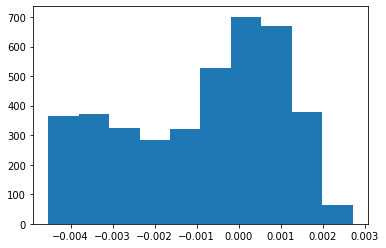

In [ ]:
plt.hist(pinn.net_f(X_res).detach().cpu().numpy())

In [ ]:
# 保存模型参数 训练记录
model_state = {'iter': it+1, 'backbone_state': pinn.backbone.state_dict(),'nn_G_state': pinn.nn_G.state_dict()}
backbone_path = os.path.join(model_path, f'backbone_adam.pth')
torch.save(model_state, backbone_path)

np.save("./loss_logger_dict.npy", logger)

In [ ]:
# 训练用时
def used_time(start_time):
    seconds = time.time() - start_time
    minutes, seconds = divmod(seconds, 60)
    hours, minutes = divmod(minutes, 60)
    print(f'used time: {hours:.0f}h {minutes:.0f}m {seconds:.0f}s')
    
used_time(start_time)

used time: 0h 17m 18s


## 结果可视化

In [ ]:
plt.rcParams.update({'font.size':18})

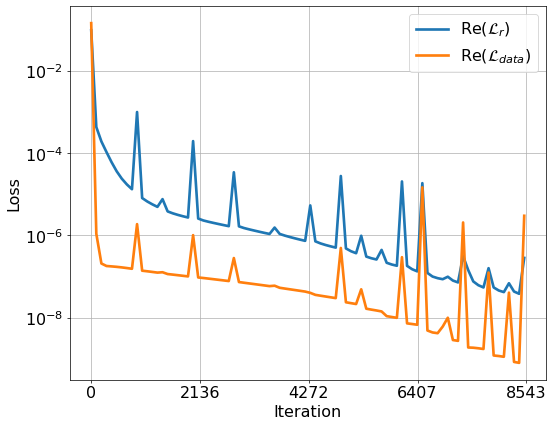

In [ ]:
# loss曲线
loss_logger = np.load("./loss_logger_dict.npy", allow_pickle=True).item()

fig = plt.figure(figsize=(9, 7), dpi=64)
ax = fig.subplots()

k_plot = 100
# ax.plot(loss_logger["iter"][::k], loss_logger["loss"][::k], label=r"$\mathcal{L}$", linewidth=3)
ax.plot(loss_logger["iter"][::k_plot], loss_logger["loss_res_pw"][::k_plot], label=r"Re($\mathcal{L}_{r})$", linewidth=3)
ax.plot(loss_logger["iter"][::k_plot], loss_logger["loss_obs_pw"][::k_plot], label=r"Re($\mathcal{L}_{data})$", linewidth=3)
ax.set_yscale('log')
ax.set_xticks(np.linspace(0, loss_logger["iter"][-1], 5))
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
ax.grid()

ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig('Loss.png', dpi=100, bbox_inches='tight')
plt.show()

In [ ]:
# 导入模型参数
mu = logger["mu"].cpu()
sigma = logger["sigma"].cpu()

backbone = MLP(mlp_layers)
nn_G = MLP(mlp_layers_G)
pinn = PINN(backbone, nn_G, mu, sigma)
model_state = torch.load(os.path.join(model_path, 'backbone_adam.pth'))
pinn.backbone.load_state_dict(model_state['backbone_state'])
pinn.nn_G.load_state_dict(model_state['nn_G_state'])
pinn.eval()

forward with normalization, mu=[0.125, 0.125], sigma=[0.07363609224557877, 0.0730857402086258]


PINN(
  (backbone): MLP(
    (model): Sequential(
      (fc1): Linear(in_features=2, out_features=60, bias=True)
      (act1): Tanh()
      (fc2): Linear(in_features=60, out_features=60, bias=True)
      (act2): Tanh()
      (fc3): Linear(in_features=60, out_features=60, bias=True)
      (act3): Tanh()
      (fc4): Linear(in_features=60, out_features=60, bias=True)
      (act4): Tanh()
      (fc5): Linear(in_features=60, out_features=60, bias=True)
      (act5): Tanh()
      (fc6): Linear(in_features=60, out_features=60, bias=True)
      (act6): Tanh()
      (fc7): Linear(in_features=60, out_features=60, bias=True)
      (act7): Tanh()
      (fc8): Linear(in_features=60, out_features=60, bias=True)
      (act8): Tanh()
      (fc9)): Linear(in_features=60, out_features=1, bias=False)
    )
  )
  (nn_G): MLP(
    (model): Sequential(
      (fc1): Linear(in_features=2, out_features=20, bias=True)
      (act1): Tanh()
      (fc2): Linear(in_features=20, out_features=20, bias=True)
      (a

In [ ]:
def fun_G(X):
    return (np.sin(4*np.pi*X[:,[0]])) * (np.sin(4*np.pi*X[:,[1]]))

dataset = Dataset(domain)
X_res, X_bcs, u_bcs, u_res = dataset.train_data()
X_res = torch.from_numpy(X_res).float().to(device)
X_bcs = torch.from_numpy(X_bcs).float().to(device)
u_bcs = torch.from_numpy(u_bcs).float().to(device)
u_res = torch.from_numpy(u_res).float().to(device)

In [ ]:
X_res= X_res.cpu().detach().numpy()
X_bcs= X_bcs.cpu().detach().numpy()
X = np.concatenate([X_res,X_bcs],axis=0)
X = torch.from_numpy(X)
# X = X.reshape(-1, 1)

G_star = fun_G(X)
G_pred = pinn.net_G(X).detach()

# G_pred = G_pred.reshape(t.shape)
print(G_star.shape)
print(G_pred.shape)
G_error = np.linalg.norm(G_pred - G_star) / np.linalg.norm(G_star)

print('Relative l2 error of G: {:.3e}'.format(G_error))

torch.Size([4260, 1])
torch.Size([4260, 1])
Relative l2 error of G: 1.028e+00


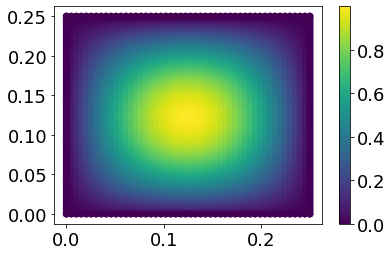

In [ ]:
plt.scatter(X[:,[0]], X[:,[1]], c=G_star)
plt.colorbar()

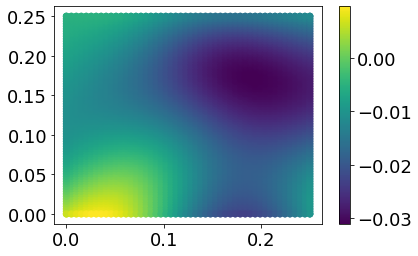

In [ ]:
plt.scatter(X[:,[0]], X[:,[1]], c=G_pred)
plt.colorbar()

In [ ]:
x = X[:,[0]]
y = X[:,[1]]
XX, YY = np.meshgrid(x, y)
XY = np.concatenate([XX.reshape(-1,1), YY.reshape(-1,1)], axis=1)
XY = torch.from_numpy(XY)

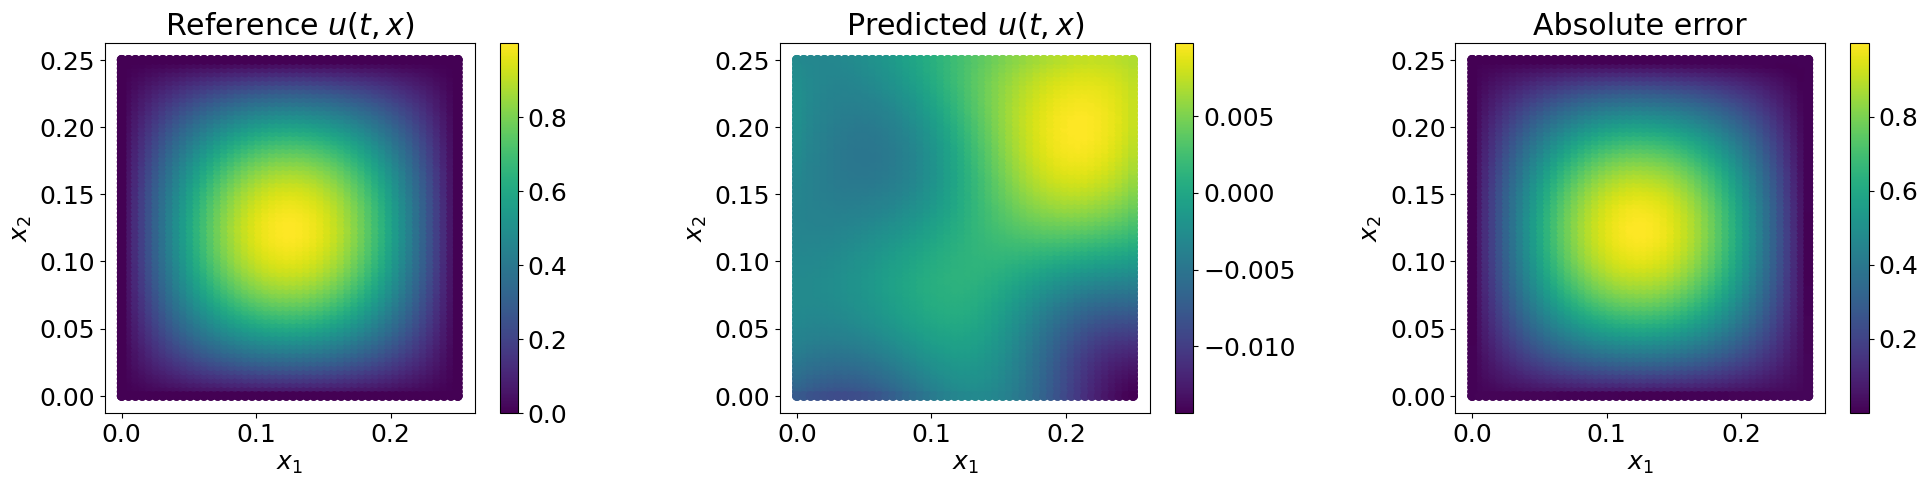

In [ ]:
fig = plt.figure(figsize=(20, 5))
axes = fig.subplots(1, 3)

cax1 = axes[0].scatter(X[:,[0]], X[:,[1]], c=G_star)
fig.colorbar(cax1)
axes[0].set_xlabel('$x_1$')
axes[0].set_ylabel('$x_2$')
axes[0].set_title(r'Reference $u(t,x)$')

axes[0].set_aspect(1./axes[0].get_data_ratio())

cax2 = axes[1].scatter(X[:,[0]], X[:,[1]], c=G_pred)
fig.colorbar(cax2)
axes[1].set_xlabel('$x_1$')
axes[1].set_ylabel('$x_2$')
axes[1].set_title(r'Predicted $u(t,x)$')
axes[1].set_aspect(1./axes[1].get_data_ratio())

cax3 = axes[2].scatter(X[:,[0]], X[:,[1]], c=np.abs(G_star - G_pred))
fig.colorbar(cax3)
axes[2].set_xlabel('$x_1$')
axes[2].set_ylabel('$x_2$')
axes[2].set_title('Absolute error')
axes[2].set_aspect(1./axes[2].get_data_ratio())

plt.tight_layout()
plt.savefig('Burgers_result.png', dpi=100, bbox_inches='tight')
plt.show()

NameError: name 'axis' is not defined

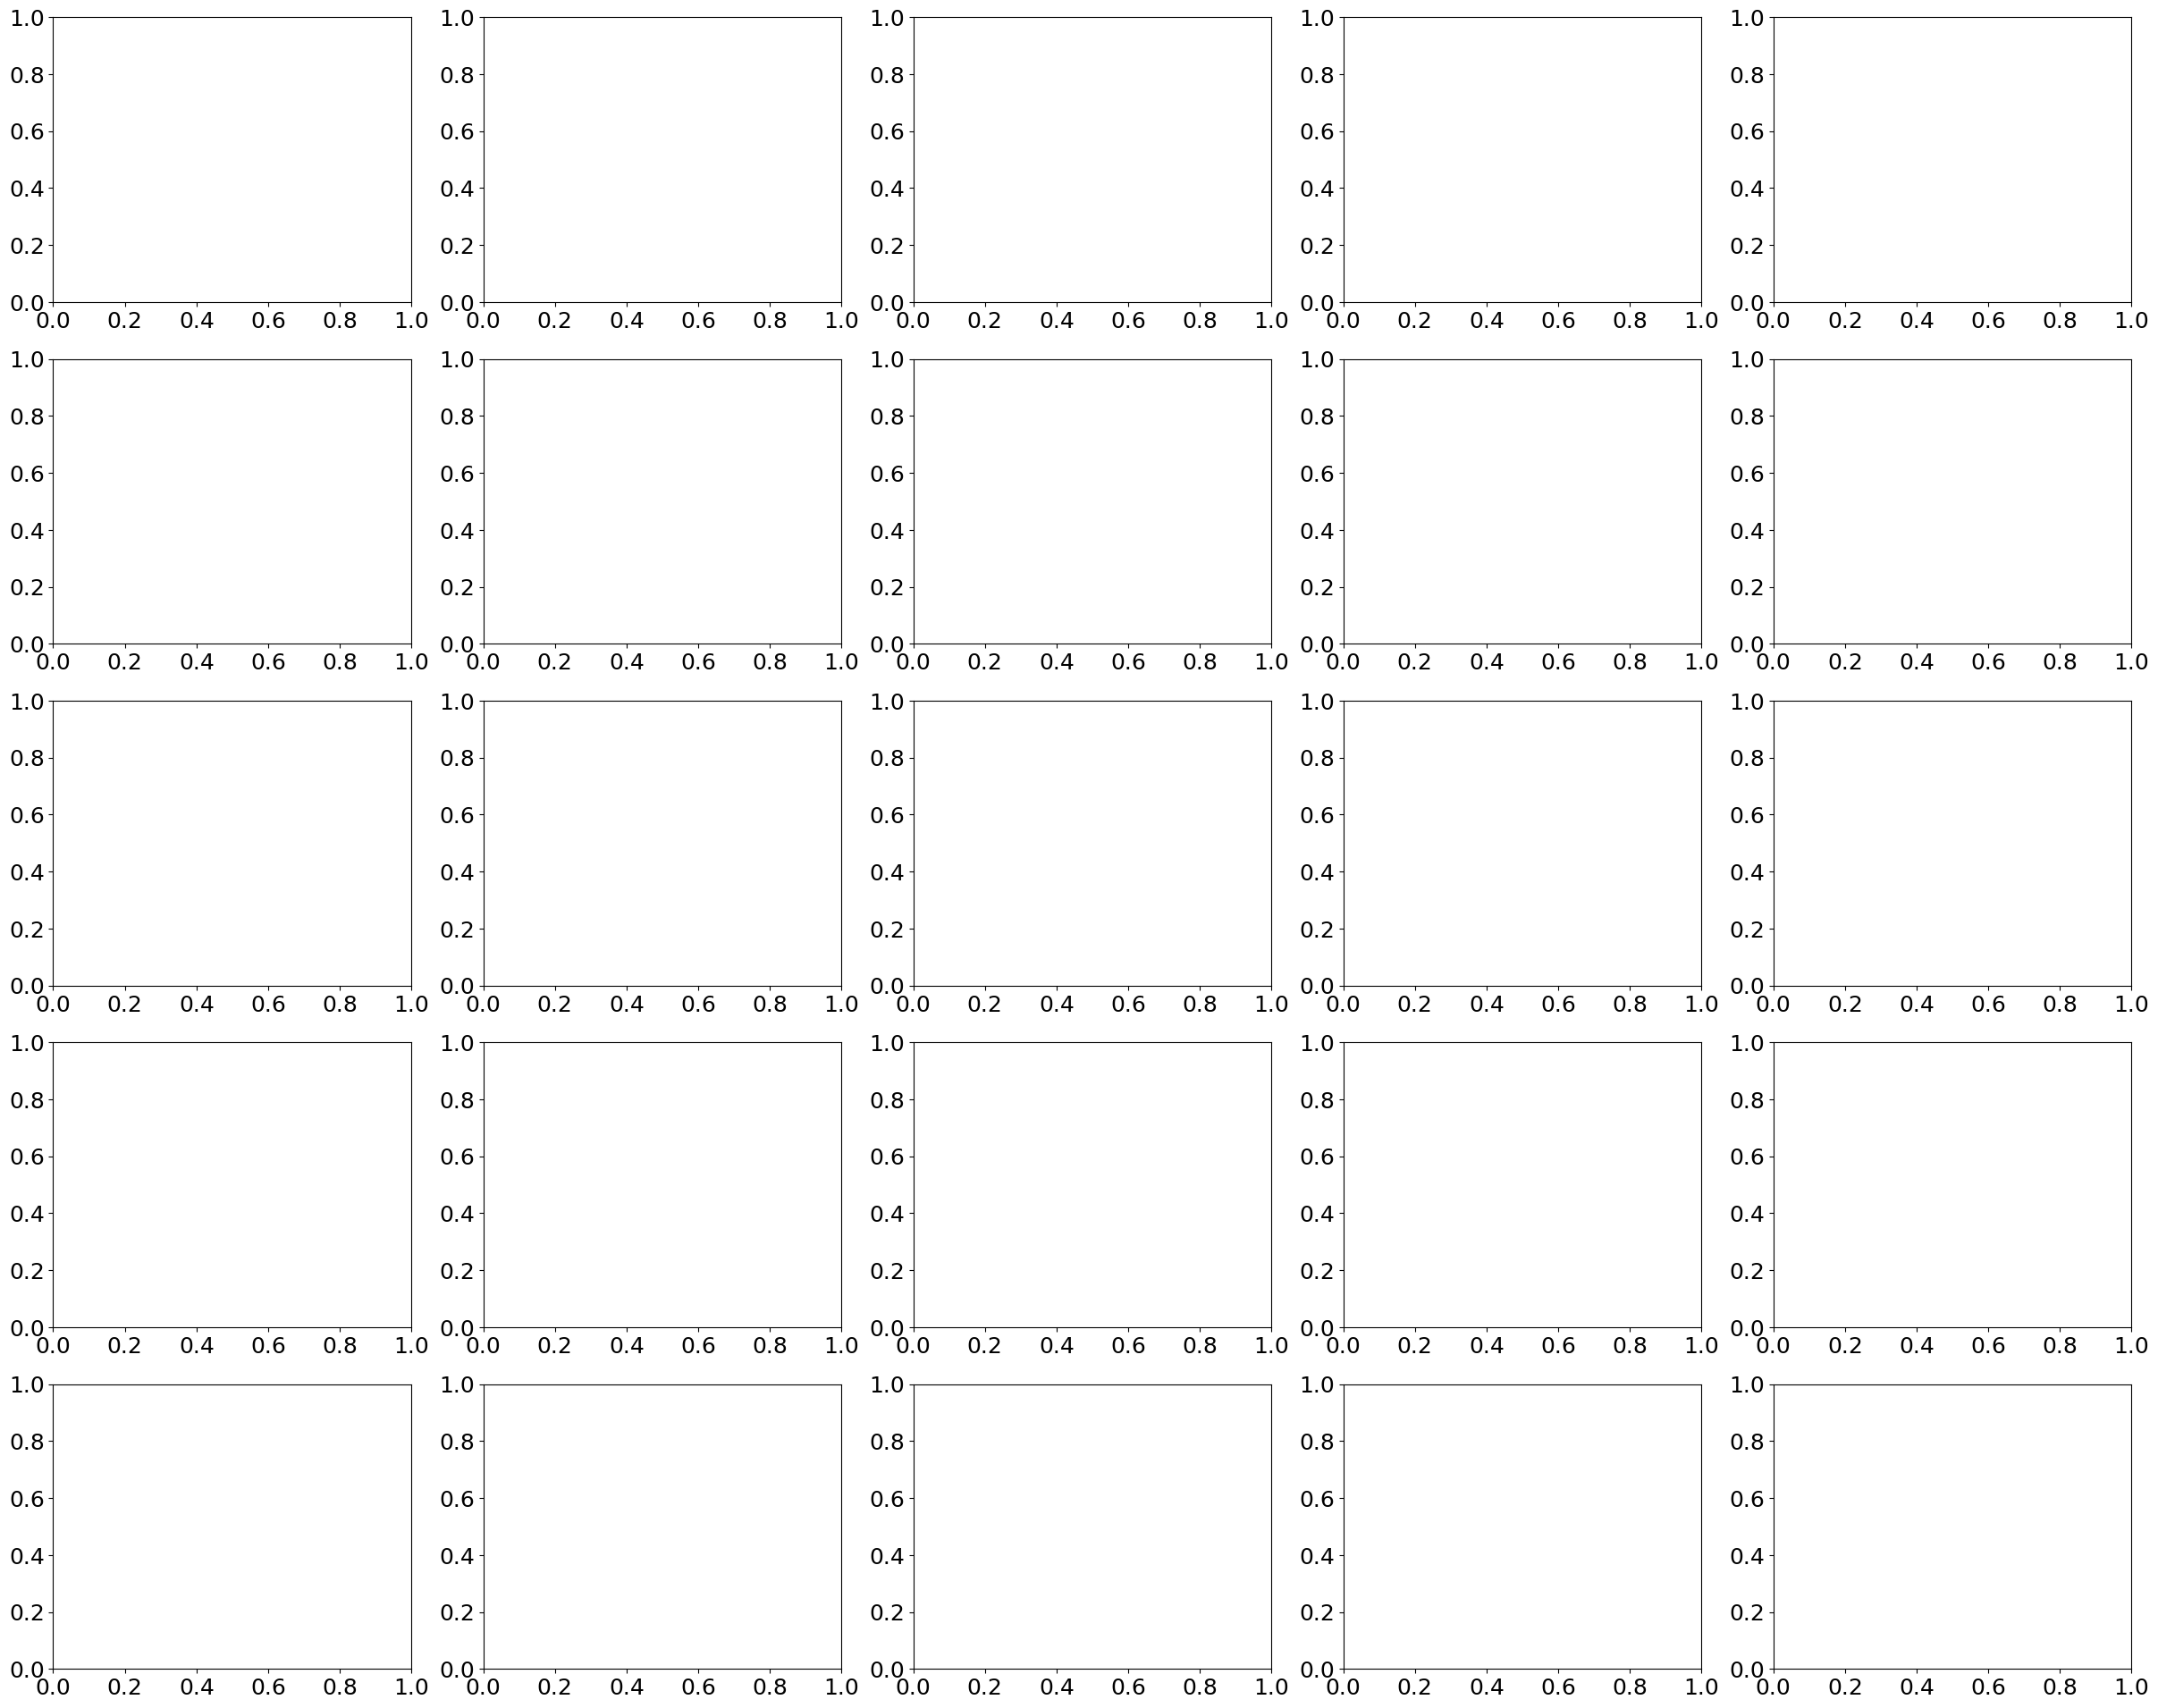

In [ ]:
fig, axs = plt.subplots(5, 5, figsize=(30, 24))  
  
for i, ax in enumerate(axs.flat):  
    # 生成随机的数据  
    index = np.where(axis == (i+1))
    horizontal_filtered = horizontal[index]  
    vertical_filtered = vertical[index]  
    axis_filtered = axis[index]  
    
    X_filtered = np.stack([horizontal_filtered.flatten(), vertical_filtered.flatten(), axis_filtered.flatten()], axis=1)
    X_filtered = torch.from_numpy(X_filtered).float()
    temperature_filtered = pinn.net_u(X_filtered)
    temperature_filtered = temperature_filtered.detach().cpu().numpy().flatten()
    
#     temperature_filtered = temperature[index] 
  
    # 在子图中绘制数据  
    cax = ax.scatter(horizontal_filtered, vertical_filtered, c=temperature_filtered, s=100)
    fig.colorbar(cax)
  
    # 设置子图的标题和标签  
    ax.set_title(r'$T(x,y,z=$' + f'{i+1}' + r')')  
    ax.set_xlabel('$x$')  
    ax.set_ylabel('$y$')  
  
    # 清除坐标轴标签和刻度  
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_xticks(np.linspace(xmin, xmax, 5))
    ax.set_yticks(np.linspace(ymin, ymax, 5))
    ax.set_aspect(1./ax.get_data_ratio())
    
plt.tight_layout()  # 调整图像布局  
  
# 显示图像  
plt.show()

In [ ]:
fig, axs = plt.subplots(5, 5, figsize=(30, 24))  
  
for i, ax in enumerate(axs.flat):  
    # 生成随机的数据  
    index = np.where(axis == (i+1))
    horizontal_filtered = horizontal[index]  
    vertical_filtered = vertical[index]  
    axis_filtered = axis[index]  
    
    X_filtered = np.stack([horizontal_filtered.flatten(), vertical_filtered.flatten(), axis_filtered.flatten()], axis=1)
    X_filtered = torch.from_numpy(X_filtered).float()
    temperature_filtered = pinn.net_u(X_filtered)
    temperature_filtered = temperature_filtered.detach().cpu().numpy().flatten()
    
    temperature_filtered_true = temperature[index] 
  
    # 在子图中绘制数据  
    cax = ax.scatter(horizontal_filtered, vertical_filtered, c=abs(temperature_filtered - temperature_filtered_true), s=100)
    fig.colorbar(cax)
  
    # 设置子图的标题和标签  
    ax.set_title('Absolute error')  
    ax.set_xlabel('$x$')  
    ax.set_ylabel('$y$')  
  
    # 清除坐标轴标签和刻度  
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_xticks(np.linspace(xmin, xmax, 5))
    ax.set_yticks(np.linspace(ymin, ymax, 5))
    ax.set_aspect(1./ax.get_data_ratio())
    
plt.tight_layout()  # 调整图像布局  
  
# 显示图像  
plt.show()

In [ ]:
fig, axs = plt.subplots(5, 5, figsize=(30, 24))  
  
for i, ax in enumerate(axs.flat):  
    # 生成随机的数据  
    index = np.where(axis == (i+1))
    horizontal_filtered = horizontal[index]  
    vertical_filtered = vertical[index]  
    axis_filtered = axis[index]  
    
    X_filtered = np.stack([horizontal_filtered.flatten(), vertical_filtered.flatten(), axis_filtered.flatten()], axis=1)
    X_filtered = torch.from_numpy(X_filtered).float()
    G_filtered = pinn.net_param(X_filtered)
    G_filtered = G_filtered.detach().cpu().numpy().flatten()
    
#     temperature_filtered = temperature[index] 
  
    # 在子图中绘制数据  
    cax = ax.scatter(horizontal_filtered, vertical_filtered, c=G_filtered, s=100)
    cbar = fig.colorbar(cax)
    cbar.formatter.set_powerlimits((-5, -5))
    cbar.update_ticks()
  
    # 设置子图的标题和标签  
    ax.set_title(r'$G(x,y,z=$' + f'{i+1}' + r')')  
    ax.set_xlabel('$x$')  
    ax.set_ylabel('$y$')  
  
    # 清除坐标轴标签和刻度  
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_xticks(np.linspace(xmin, xmax, 5))
    ax.set_yticks(np.linspace(ymin, ymax, 5))
    ax.set_aspect(1./ax.get_data_ratio())
    
plt.tight_layout()  # 调整图像布局  
  
# 显示图像  
plt.show()

In [ ]:
# import scipy.io as io
# io.savemat('./HelmholtzPINNsDiscovery.mat',{
#     'x':x_test, 
#     'y':x_test,
#     'xx':xx,
#     'yy':yy, 
#     'uu':uu, 
#     'vv':vv, 
#     'kk':kk, 
#     'uu_pred':uu_pred, 
#     'vv_pred':vv_pred, 
#     'kk_pred':kk_pred
# })